<a href="https://colab.research.google.com/github/guimarczewski/GUILHERME_MARCZEWSKI_DDF_DATAANALYST_112023/blob/main/spacemanidol_product_search_corpus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libs

First, let's install and import the necessary libs.

In [ ]:
!pip install datasets;
!pip install openai==0.28

In [ ]:
import time
import csv
import os

import requests
import pandas as pd
import numpy as np

from datasets import load_dataset
import openai

#Download Dataset

Now let's download the dataset used according to the following documentation:

https://huggingface.co/docs/hub/datasets-downloading

In [ ]:
dataset = load_dataset("spacemanidol/product-search-corpus")

df_dataset = pd.DataFrame(dataset["train"])

print(df_dataset.head())

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  docid                                              title  \
0     1  FYY Leather Case with Mirror for Samsung Galax...   
1     2  Playtex Women's 18 Hour Easy On, Easy Off Fron...   
2     4  YUEPIN U-Tube Clamp 304 Stainless Steel Hose P...   
3     5            Bruce's Big Storm (Mother Bruce Series)   
4     6  DJI Shoulder Neck Strap Belt Sling Lanyard Nec...   

                                                text  
0  Product Description Premium PU Leather Top qua...  
1  Product Description Introducing Playtex 18 hou...  
2  Product Description Specification: Material: 3...  
3                                                     
4  Product Description Specifications: Item Condi...  


Devido ao custo de processamento, para esse case será utilizado apenas uma amostra do dataset, contendo 20 linhas, mas que irá representar bem como é o funcionamento desse tratamento de dados.

In [ ]:
df = df_dataset.head(20)
print(df.head())

  docid                                              title  \
0     1  FYY Leather Case with Mirror for Samsung Galax...   
1     2  Playtex Women's 18 Hour Easy On, Easy Off Fron...   
2     4  YUEPIN U-Tube Clamp 304 Stainless Steel Hose P...   
3     5            Bruce's Big Storm (Mother Bruce Series)   
4     6  DJI Shoulder Neck Strap Belt Sling Lanyard Nec...   

                                                text  
0  Product Description Premium PU Leather Top qua...  
1  Product Description Introducing Playtex 18 hou...  
2  Product Description Specification: Material: 3...  
3                                                     
4  Product Description Specifications: Item Condi...  


# Web Scraper to extract Amazon's Departments

To define the product categories in the dataset, we will use the departments on the Amazon website. To do this, let's make a simple scraper using Selenium to take this information and put it in a list to be used later.

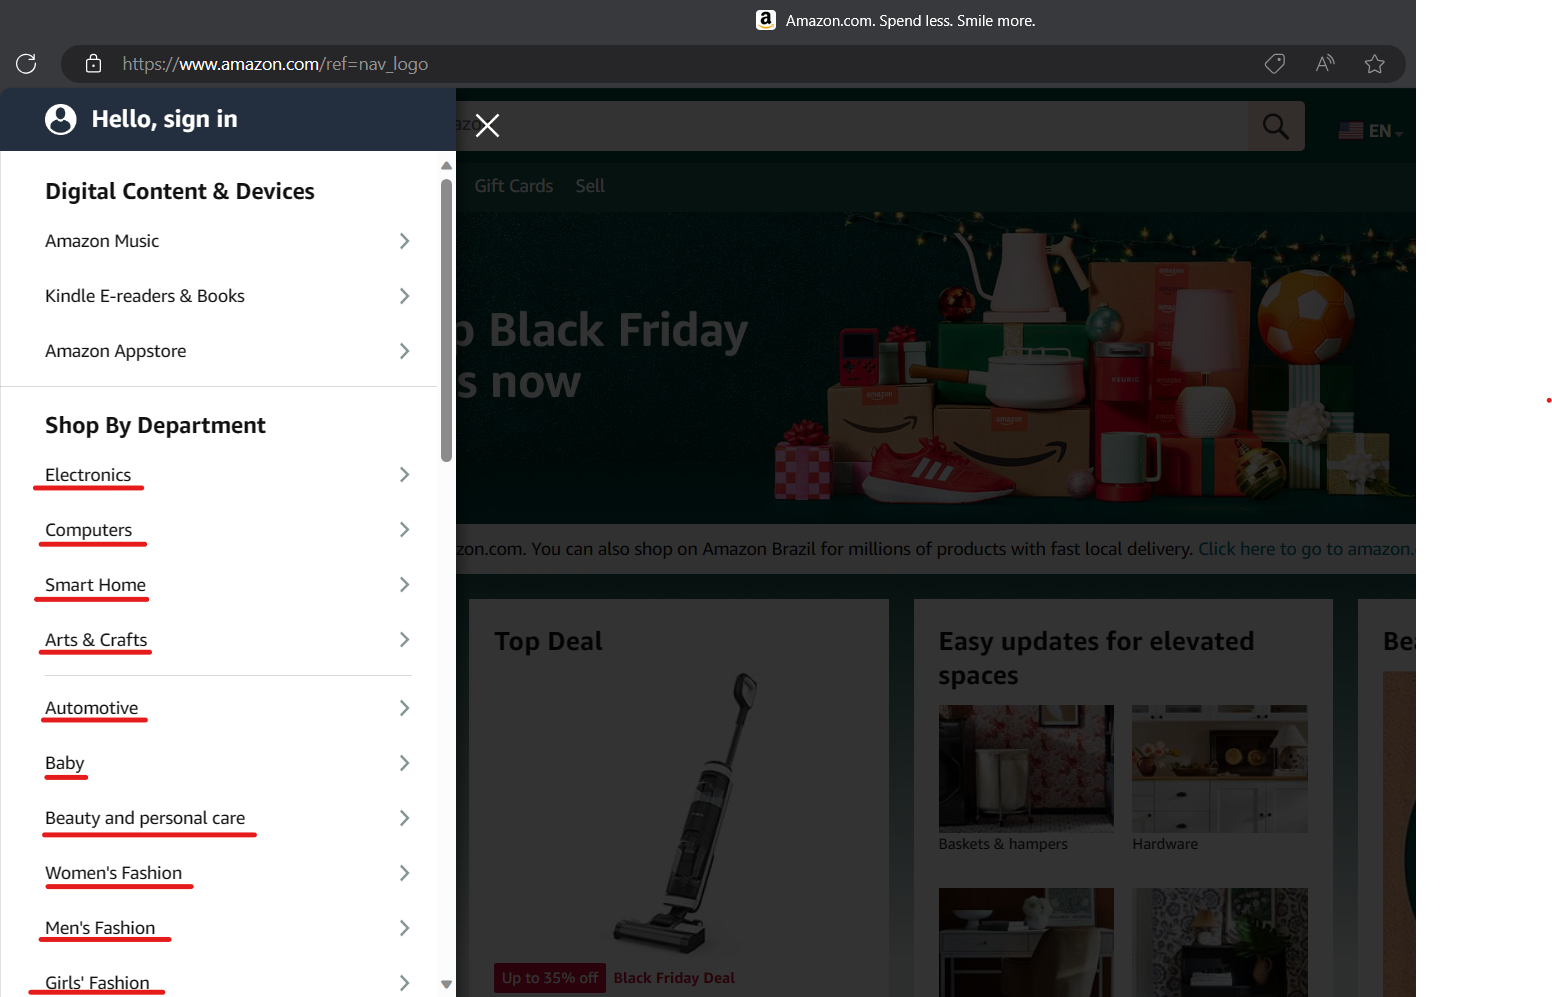

In [ ]:
# import libs
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.chrome.options import Options

# Start the browser headless
chrome_options = Options()
chrome_options.add_argument("--headless")
driver = webdriver.Chrome(options=chrome_options)

# Open the HTML page
driver.get("https://www.amazon.com")

# Wait for a while to ensure that the page is fully loaded (adjust as needed)
driver.implicitly_wait(10)

# Find the element using XPath to open the menu
hamburger_menu = driver.find_element(By.XPATH, '//*[@id="nav-hamburger-menu"]/i')

# Click on the element
ActionChains(driver).move_to_element(hamburger_menu).click().perform()

# Find the element using XPath to see all departments
see_all = driver.find_element(By.XPATH, '//*[@id="hmenu-content"]/ul[1]/li[11]/a[1]')

# Click on the element
ActionChains(driver).move_to_element(see_all).click().perform()

# Find the <a> elements within the menu using XPath to select all departments
menu_elements = driver.find_elements(By.XPATH, '//*[@data-menu-id>=5 and @data-menu-id<=26]')

# Extract the text from the divs within the <a> elements and put it in a list, excluding empty elements
categories = [element.find_element(By.XPATH, './/div').text.strip() for element in menu_elements if element.find_element(By.XPATH, './/div').text.strip()]

# Print the list
print(categories)



```
categories = ['Electronics', 'Computers', 'Smart Home', 'Arts & Crafts', 'Automotive', 'Baby', 'Beauty and personal care', "Women's Fashion", "Men's Fashion", "Girls' Fashion", "Boys' Fashion", 'Health and Household', 'Home and Kitchen', 'Industrial and Scientific', 'Luggage', 'Movies & Television', 'Pet supplies', 'Software', 'Sports and Outdoors', 'Tools & Home Improvement', 'Toys and Games', 'Video Games']
```



In [ ]:
categories = ['Electronics', 'Computers', 'Smart Home', 'Arts & Crafts', 'Automotive', 'Baby', 'Beauty and personal care', "Women's Fashion", "Men's Fashion", "Girls' Fashion", "Boys' Fashion", 'Health and Household', 'Home and Kitchen', 'Industrial and Scientific', 'Luggage', 'Movies & Television', 'Pet supplies', 'Software', 'Sports and Outdoors', 'Tools & Home Improvement', 'Toys and Games', 'Video Games']

# OpenAI API to extract features

Let's use the OpenAi API to extract the features from the "text" column of our DataFrame and place them in a new column called "features".

In [ ]:
# Define the OpenAI API Key
openai.api_key = <API_KEY>

df = df

# Function to extract features
def extract_features(row):
    title = row['title']
    description = row['text']

    prompt = f"Given the product title: '{title}' and its description: '{description}', extract its main physical features in a Json format with name 'features'. Answer just with the JSON, no more text or annotations."

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )

    return response.choices[0].message['content'].strip()

# Apply the function to the 'features' column
df['features'] = df.apply(extract_features, axis=1)

# Show df
print(df.head())

  docid                                              title  \
0     1  FYY Leather Case with Mirror for Samsung Galax...   
1     2  Playtex Women's 18 Hour Easy On, Easy Off Fron...   
2     4  YUEPIN U-Tube Clamp 304 Stainless Steel Hose P...   
3     5            Bruce's Big Storm (Mother Bruce Series)   
4     6  DJI Shoulder Neck Strap Belt Sling Lanyard Nec...   

                                                text  \
0  Product Description Premium PU Leather Top qua...   
1  Product Description Introducing Playtex 18 hou...   
2  Product Description Specification: Material: 3...   
3                                                      
4  Product Description Specifications: Item Condi...   

                                            features  
0  {\n  "features": {\n    "material": "Premium P...  
1  {\n  "features": {\n    "name": "Playtex Women...  
2  {\n  "features": {\n    "material": "304 Stain...  
3  {\n  "features": {\n    "title": "Bruce's Big ...  
4  {\n  "featur

<ipython-input-16-15ec6fb8d739>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['features'] = df.apply(extract_features, axis=1)


Now let's use the API again to fit each product, according to the title and text, into one of the categories that we extracted from the Amazon website, placing it in the "category" column.

In [ ]:
# Define the OpenAI API Key
openai.api_key = <API_KEY>

df = df

# Function to extract category
def extract_features(row):
    title = row['title']
    description = row['text']

    prompt = f"Given the product title: '{title}' and its description: '{description}', classify using the title and description using the categories: {categories}. Answer just with the category defined, no more comments or annotations. "

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
        #,max_tokens=150
    )

    return response.choices[0].message['content'].strip()

# Apply the function to the 'features' column
df['category'] = df.apply(extract_features, axis=1)

# Show df
print(df)

   docid                                              title  \
0      1  FYY Leather Case with Mirror for Samsung Galax...   
1      2  Playtex Women's 18 Hour Easy On, Easy Off Fron...   
2      4  YUEPIN U-Tube Clamp 304 Stainless Steel Hose P...   
3      5            Bruce's Big Storm (Mother Bruce Series)   
4      6  DJI Shoulder Neck Strap Belt Sling Lanyard Nec...   
5      7  Crocs Jibbitz 5-Pack Alien Shoe Charms | Jibbi...   
6     10  Design Toscano QM2787100 Darby, the Forest Faw...   
7     11  Zeagoo Women's Open Front Cardigan 3/4 Sleeve ...   
8     12  Rekayla Open Toe Tie Up Ankle Wrap Flat Sandal...   
9     13  Apron for Women, Waterproof Adjustable Bib Coo...   
10    14  DIY 5D Diamond Painting by Number Kit for Adul...   
11    19  Under Armour Men's Micro G Pursuit-Wide Sneake...   
12    21  Drake Feelings MyFaveGift Drizzy Champagne Pap...   
13    22           Spider-Man: Homecoming Spider Sight Mask   
14    23               Tee Luv ICEE Polar Bear Logo T-S

<ipython-input-19-0bc8843f32b9>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'] = df.apply(extract_features, axis=1)


# Correcting the data

Although we stated in the prompt that we only wanted the category, in some cases the API may return some more text, as seen in the sixth line of the DataFrame.

To fix this, let's create a function to do a mapping and check which item from the input list is present in the category column, replacing the full text with just the value from the list.

In [23]:
# Function to fix values
def map_values(value):
    for mapping_value in categories:
        if mapping_value in value:
            return mapping_value
    return value

# Apply function
df['category'] = df['category'].apply(lambda x: map_values(x))

# Print DataFrame after mapping
print(df)


   docid                                              title  \
0      1  FYY Leather Case with Mirror for Samsung Galax...   
1      2  Playtex Women's 18 Hour Easy On, Easy Off Fron...   
2      4  YUEPIN U-Tube Clamp 304 Stainless Steel Hose P...   
3      5            Bruce's Big Storm (Mother Bruce Series)   
4      6  DJI Shoulder Neck Strap Belt Sling Lanyard Nec...   
5      7  Crocs Jibbitz 5-Pack Alien Shoe Charms | Jibbi...   
6     10  Design Toscano QM2787100 Darby, the Forest Faw...   
7     11  Zeagoo Women's Open Front Cardigan 3/4 Sleeve ...   
8     12  Rekayla Open Toe Tie Up Ankle Wrap Flat Sandal...   
9     13  Apron for Women, Waterproof Adjustable Bib Coo...   
10    14  DIY 5D Diamond Painting by Number Kit for Adul...   
11    19  Under Armour Men's Micro G Pursuit-Wide Sneake...   
12    21  Drake Feelings MyFaveGift Drizzy Champagne Pap...   
13    22           Spider-Man: Homecoming Spider Sight Mask   
14    23               Tee Luv ICEE Polar Bear Logo T-S

<ipython-input-23-3842eefb0e80>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'] = df['category'].apply(lambda x: map_values(x))


# Final Result

In [24]:
from IPython.display import display

display(df)

,docid,title,text,features,category
0,1,FYY Leather Case with Mirror for Samsung Galax...,Product Description Premium PU Leather Top qua...,"{\n ""features"": {\n ""material"": ""Premium P...",Electronics
1,2,"Playtex Women's 18 Hour Easy On, Easy Off Fron...",Product Description Introducing Playtex 18 hou...,"{\n ""features"": {\n ""name"": ""Playtex Women...",Women's Fashion
2,4,YUEPIN U-Tube Clamp 304 Stainless Steel Hose P...,Product Description Specification: Material: 3...,"{\n ""features"": {\n ""material"": ""304 Stain...",Industrial and Scientific
3,5,Bruce's Big Storm (Mother Bruce Series),,"{\n ""features"": {\n ""title"": ""Bruce's Big ...",Books
4,6,DJI Shoulder Neck Strap Belt Sling Lanyard Nec...,Product Description Specifications: Item Condi...,"{\n ""features"": {\n ""Item Condition"": ""Bra...",Electronics
5,7,Crocs Jibbitz 5-Pack Alien Shoe Charms | Jibbi...,From the brand Previous page Shop Crocs Collec...,"{\n ""features"": {\n ""Brand"": ""Crocs"",\n ...",Toys and Games
6,10,"Design Toscano QM2787100 Darby, the Forest Faw...",,"{\n ""features"": {\n ""product_title"": ""Desi...",Home and Kitchen
7,11,Zeagoo Women's Open Front Cardigan 3/4 Sleeve ...,From the brand Lightweight Cardigan Previous p...,"{\n ""features"": {\n ""productTitle"": ""Zeago...",Women's Fashion
8,12,Rekayla Open Toe Tie Up Ankle Wrap Flat Sandal...,From the brand Previous page REKAYLA is a fres...,"{\n ""features"": {\n ""Product Title"": ""Reka...",Women's Fashion
9,13,"Apron for Women, Waterproof Adjustable Bib Coo...",,"{\n ""features"": {\n ""title"": ""Apron for Wo...",Home and Kitchen


# Saving DataFrame
As there are several commas in the "text" column, this can cause problems when reading the dataFrame. To avoid this, the semicolon will be used as a separator.

In [27]:
# Save DataFrame as CSV
df.to_csv('/content/sample_data/product-search-corpus.csv', index=False, sep=';')